<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_11_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Hyperparameter Tuning

#### What are Hyperparameters?

In machine learning, hyperparameters are parameters that are set before the learning process begins. They control the behavior of the learning algorithm and influence the model's performance. Unlike model parameters (e.g., weights in a neural network), hyperparameters are not learned from the data during training. Examples of hyperparameters include:

- **Learning Rate**: Controls how much to change the model in response to the estimated error each time the model weights are updated.
- **Number of Epochs**: The number of complete passes through the training dataset.
- **Batch Size**: The number of training examples used in one iteration.
- **Network Architecture**: The number of layers and number of neurons per layer in a neural network.
- **Regularization Parameters**: Parameters like dropout rate or L2 regularization that help prevent overfitting.

#### Why is Hyperparameter Tuning Important?

Hyperparameter tuning is crucial because it directly affects the performance and generalizability of a machine learning model. Poorly chosen hyperparameters can lead to:

- **Overfitting**: The model performs well on training data but poorly on unseen data.
- **Underfitting**: The model is too simple to capture the underlying patterns in the data.
- **Slow Convergence**: Training takes longer than necessary due to inefficient learning rates or batch sizes.
- **Poor Performance**: The model's overall accuracy, precision, recall, or other metrics are suboptimal.

#### Methods for Hyperparameter Tuning

1. **Grid Search**:
   - **Definition**: An exhaustive search over a specified parameter grid.
   - **Process**: Defines a set of hyperparameters and their possible values, then evaluates the model performance for all possible combinations.
   - **Advantages**: Simple to understand and implement.
   - **Disadvantages**: Computationally expensive, especially for large grids and datasets.

2. **Random Search**:
   - **Definition**: Randomly samples hyperparameters from a specified distribution.
   - **Process**: Defines a range for each hyperparameter and randomly picks combinations to evaluate.
   - **Advantages**: Often finds good hyperparameter combinations with less computation than grid search.
   - **Disadvantages**: Still may require a significant number of evaluations for large hyperparameter spaces.

3. **Bayesian Optimization**:
   - **Definition**: Uses probabilistic models to find the optimal hyperparameters.
   - **Process**: Builds a probabilistic model of the objective function and uses it to select the most promising hyperparameters to evaluate.
   - **Advantages**: Efficient and effective for high-dimensional hyperparameter spaces.
   - **Disadvantages**: More complex to implement and understand.

4. **Gradient-Based Optimization**:
   - **Definition**: Uses gradient information to optimize hyperparameters.
   - **Process**: Adjusts hyperparameters based on the gradient of the performance metric with respect to the hyperparameters.
   - **Advantages**: Can be very efficient for certain types of models.
   - **Disadvantages**: Not applicable to all types of models and hyperparameters.

5. **Automated Hyperparameter Tuning Tools**:
   - **Examples**: HyperOpt, Optuna, AutoKeras, Auto-sklearn.
   - **Advantages**: These tools often combine several advanced techniques to find optimal hyperparameters efficiently.
   - **Disadvantages**: May require some setup and understanding of the tool.

#### Key Considerations for Hyperparameter Tuning

- **Performance Metric**: Choose an appropriate performance metric (e.g., F1 score, accuracy, AUC) that aligns with the business or research goals.
- **Computational Resources**: Balance the thoroughness of the search with the available computational resources and time.
- **Validation Strategy**: Use cross-validation or a separate validation set to ensure the hyperparameter tuning results generalize well to unseen data.

### Summary

Hyperparameter tuning is a critical step in the machine learning pipeline that helps optimize model performance and generalizability. By carefully selecting and tuning hyperparameters, you can significantly enhance your model's effectiveness and efficiency.

### Load and Preprocess the Data

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules
from data_utils import (
    load_data_from_url, clean_column_names, remove_id_column, rename_columns,
    convert_categorical, split_data, preprocess_data, define_preprocessor,
    calculate_class_weights, convert_to_tensors, load_and_preprocess_data
)
from model_definition import SklearnSimpleNN, SimpleNN
from model_pipeline import (
    apply_feature_engineering, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)
from model_evaluation import evaluate_class_weights, class_weights_to_dataframe

# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.40

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
target = 'default_payment_next_month'  # Specify your target column

data, target = load_and_preprocess_data(url, categorical_columns, target)

# Apply feature engineering
data = apply_feature_engineering(data)

# Split the data
X_train, X_test, y_train, y_test = split_data(data, target=target)

### Learning Rate

#### What is the Learning Rate?

The **learning rate** is a hyperparameter that controls how much to change the model's parameters (e.g., weights) in response to the estimated error each time the model weights are updated. It determines the size of the steps taken during gradient descent optimization.

#### Impact of Learning Rate on Training

1. **Too High Learning Rate**:
   - **Overshooting**: If the learning rate is too high, the optimization process may overshoot the optimal parameters, leading to oscillations or divergence.
   - **Unstable Training**: High learning rates can cause the model to become unstable and fail to converge.

2. **Too Low Learning Rate**:
   - **Slow Convergence**: If the learning rate is too low, the model will update the parameters very slowly, leading to prolonged training times.
   - **Local Minima**: Low learning rates may also cause the model to get stuck in local minima, preventing it from finding the global optimum.

3. **Optimal Learning Rate**:
   - **Efficient Convergence**: An appropriately chosen learning rate will allow the model to converge efficiently to the optimal parameters.
   - **Balanced Training**: The right learning rate balances the speed of convergence with the stability of the training process.

#### Techniques for Adjusting Learning Rate

1. **Learning Rate Schedules**:
   - **Fixed Schedule**: Predefined adjustments to the learning rate at specific epochs (e.g., reducing the learning rate by half every 10 epochs).
   - **Exponential Decay**: Gradually decreases the learning rate according to an exponential decay function.
   - **Step Decay**: Reduces the learning rate by a factor at specific intervals.
   - **Piecewise Constant Decay**: Applies different fixed learning rates for different ranges of epochs.

2. **Adaptive Learning Rate Methods**:
   - **AdaGrad**: Adjusts the learning rate based on the historical gradients.
   - **RMSprop**: Uses a moving average of squared gradients to normalize the gradient.
   - **Adam**: Combines the ideas of AdaGrad and RMSprop by maintaining a moving average of both the gradients and their squares.

#### Practical Tips for Choosing Learning Rate

1. **Start with a Range**: Experiment with a range of learning rates (e.g., 0.001, 0.01, 0.1) to find a good starting point.
2. **Learning Rate Finder**: Use techniques like learning rate finder, which gradually increases the learning rate during training and plots the loss to identify the optimal range.
3. **Monitor Training**: Keep an eye on training and validation loss curves to detect signs of instability (too high) or slow convergence (too low).
4. **Adjust Dynamically**: Be prepared to adjust the learning rate dynamically based on the training progress.

### Summary

The learning rate is a crucial hyperparameter that significantly affects the training process of a machine learning model. Finding the right learning rate involves balancing the speed of convergence with the stability of the training process. By understanding the impact of the learning rate and using appropriate techniques to adjust it, you can improve the efficiency and effectiveness of your model training.

Next, we can explore another hyperparameter, such as the number of epochs or batch size. Let me know which one you would like to learn about next!

### Define and Evaluate Learning Rates

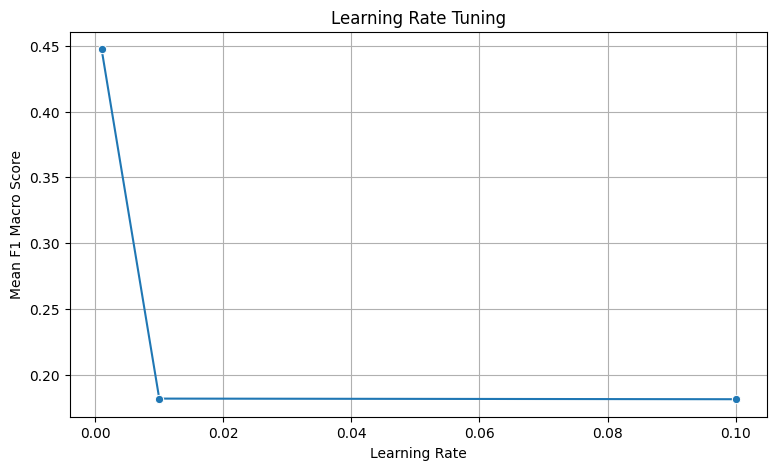

In [6]:
# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1]

# Store the results
learning_rate_results = []

# Perform cross-validation for each learning rate
for lr in learning_rates:
    # Define the neural network estimator with the current learning rate
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=lr, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    learning_rate_results.append({'learning_rate': lr, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
learning_rate_results_df = pd.DataFrame(learning_rate_results)

# Plot the results
plt.figure(figsize=(9,5))
sns.lineplot(data=learning_rate_results_df, x='learning_rate', y='f1_macro_mean', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean F1 Macro Score')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()


In [4]:
print(learning_rate_results_df)

   learning_rate  f1_macro_mean
0          0.001       0.447473
1          0.010       0.181742
2          0.100       0.181266


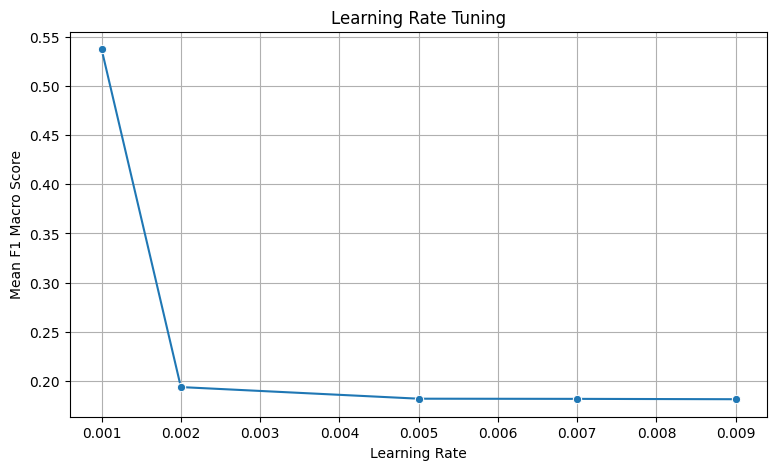

In [7]:
# Define a finer range of learning rates below 0.010
learning_rates = [0.001, 0.002, 0.005, 0.007, 0.009]

# Store the results
learning_rate_results = []

# Perform cross-validation for each learning rate
for lr in learning_rates:
    # Define the neural network estimator with the current learning rate
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=lr, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    learning_rate_results.append({'learning_rate': lr, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
learning_rate_results_df = pd.DataFrame(learning_rate_results)

# Plot the results
plt.figure(figsize=(9,5))
sns.lineplot(data=learning_rate_results_df, x='learning_rate', y='f1_macro_mean', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean F1 Macro Score')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()


In [8]:
learning_rate_results_df

,learning_rate,f1_macro_mean
0,0.001,0.537423
1,0.002,0.193744
2,0.005,0.181920
3,0.007,0.181746
4,0.009,0.181385


#### Learning Rate Results

The results indicate that the learning rate significantly impacts the performance of your model, as measured by the mean F1 macro score. Here's an interpretation of the results:

- **0.001:** The mean F1 macro score is **0.537423**, which is significantly higher than the scores for the other learning rates. This indicates that a learning rate of 0.001 is optimal for your model, providing the best balance between precision and recall.
- **0.002:** The mean F1 macro score drops sharply to **0.193744**. This suggests that the learning rate is too high, causing the model to converge too quickly and possibly miss the optimal solution.
- **0.005:** The mean F1 macro score further decreases to **0.181920**, indicating that this learning rate is too high and the model performance is poor.
- **0.007:** The mean F1 macro score is **0.181746**, which is very close to the score for the 0.005 learning rate. This suggests that the learning rate is still too high and not suitable for the model.
- **0.009:** The mean F1 macro score is **0.181385**, showing no significant improvement and confirming that this learning rate is too high.

### Conclusion

- **Optimal Learning Rate:** The learning rate of **0.001** is the best choice for your model, as it yields the highest mean F1 macro score.
- **Learning Rate Sensitivity:** Your model is sensitive to changes in the learning rate. Small increases above 0.001 lead to a significant drop in performance.
- **Next Steps:** You can proceed with the learning rate of 0.001 for further model tuning and evaluation. If desired, you can also test learning rates slightly below 0.001 to see if there is any further improvement.

This fine-tuning ensures that your model's learning process is stable and effective, leading to better performance in predicting loan defaults.

In [ ]:
# Define a range of batch sizes
batch_sizes = [16, 32, 64, 128]

# Store the results
batch_size_results = []

# Perform cross-validation for each batch size
for bs in batch_sizes:
    # Define the neural network estimator with the current batch size
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=0.001, batch_size=bs, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    batch_size_results.append({'batch_size': bs, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
batch_size_results_df = pd.DataFrame(batch_size_results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=batch_size_results_df, x='batch_size', y='f1_macro_mean', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Mean F1 Macro Score')
plt.title('Batch Size Tuning')
plt.grid(True)
plt.show()


#### Write Data Utils Script

In [1]:
# function to write script
script_content = """
# data_utils.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

# Load and Preprocess Data
def load_and_preprocess_data(url, categorical_columns, target):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    return data, target

"""

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# reload script to make function available for use
import importlib
import data_utils
importlib.reload(data_utils)

Script successfully written to data_utils.py


<module 'data_utils' from '/content/data_utils.py'>

#### Write Model Definition Script

In [2]:
script_content = """
# model_definition.py

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
#     def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
#                  pos_weight=1.0, threshold=0.5):
#         self.input_dim = input_dim
#         self.learning_rate = learning_rate
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.pos_weight = pos_weight
#         self.threshold = threshold
#         self.model = SimpleNN(self.input_dim)

#     def fit(self, X, y):
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
#         train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
#         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

#         for epoch in range(self.epochs):
#             self.model.train()
#             for inputs, targets in train_loader:
#                 optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = criterion(outputs, targets.view(-1, 1))
#                 loss.backward()
#                 optimizer.step()
#         return self

#     def predict(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             if isinstance(X, np.ndarray):
#                 X = torch.tensor(X, dtype=torch.float32)
#             elif isinstance(X, pd.DataFrame):
#                 X = torch.tensor(X.values, dtype=torch.float32)
#             outputs = self.model(X)
#             probabilities = torch.sigmoid(outputs)
#             predictions = (probabilities > self.threshold).float()
#         return predictions.numpy().squeeze()

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            elif isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

"""

# Write the script to a file
with open("model_definition.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_definition.py")

# reload script to make function available for use
import importlib
import model_definition
from model_definition import SklearnSimpleNN, SimpleNN
importlib.reload(model_definition)

Script successfully written to model_definition.py


<module 'model_definition' from '/content/model_definition.py'>

#### Write Feature Engineering Script

In [3]:
script_content = """
# feature_engineering.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from data_utils import split_data, preprocess_data, define_preprocessor, convert_to_tensors

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Incrementally Add Features and Evaluate
def add_features_incrementally(data, features_to_add, target, pos_weight, threshold):
    from model_pipeline import SklearnSimpleNN, train_model, evaluate_model
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=feature['name'])
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    return comparison_df

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df

def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

# Define a function to extract the metrics and convert to DataFrame
def results_to_dataframe(incremental_results):
    # List to hold the structured data
    data = []

    # Iterate over the results
    for result in incremental_results:
        feature_name = result['feature']
        report = result['report']

        # Initialize a dictionary to hold the flattened report
        flattened_report = {'feature': feature_name}

        # Flatten the report dictionary
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict

        # Append the flattened report to the data list
        data.append(flattened_report)

    # Convert the data list to a DataFrame
    results_df = pd.DataFrame(data)

    return results_df

"""

# Write the functions to feature_engineering.py script
with open("feature_engineering.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to feature_engineering.py")

# reload script to make function available for use
import importlib
import feature_engineering
importlib.reload(feature_engineering)


Functions successfully written to feature_engineering.py


<module 'feature_engineering' from '/content/feature_engineering.py'>

#### Write Pipeline Script

In [4]:
script_content = """
# model_pipeline.py

import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from data_utils import (
    load_data_from_url, clean_column_names, remove_id_column, rename_columns,
    convert_categorical, split_data, preprocess_data, define_preprocessor,
    calculate_class_weights, convert_to_tensors
)
from model_definition import SklearnSimpleNN
from feature_engineering import (
    create_bill_to_limit_ratios, create_payment_to_limit_ratios,
    create_payment_timeliness_features, create_lagged_payment_differences
)
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Apply feature engineering
def apply_feature_engineering(data):
    data = create_bill_to_limit_ratios(data)
    data = create_payment_to_limit_ratios(data)
    data = create_payment_timeliness_features(data)
    data = create_lagged_payment_differences(data)
    return data

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)

"""

# Write the script to a file
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)

Script successfully written to model_pipeline.py


<module 'model_pipeline' from '/content/model_pipeline.py'>

#### Write Resampling Script

In [5]:
script_content = """
# resampling_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_bill_to_limit_ratios, create_payment_to_limit_ratios,
    create_payment_timeliness_features, create_lagged_payment_differences
)

def run_resampling_pipeline(data, target, resampling_method=None, pos_weight=1.0, threshold=0.5):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

def reports_to_dataframe(reports):
    data = []
    for method, report in reports.items():
        flattened_report = {'method': method}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='method', y=metric, hue='feature_set', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Resampling Method')
    plt.ylabel(ylabel)
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)
    plt.show()

"""

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to resampling_utils.py")

# Reload the script to make the functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)


Functions successfully written to resampling_utils.py


<module 'resampling_utils' from '/content/resampling_utils.py'>

#### Write Model Evaluation Script

In [6]:
script_content = """
# model_evaluation.py

import pandas as pd
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from imblearn.pipeline import Pipeline as ImbPipeline

def evaluate_thresholds(data, target, thresholds, resampling_method=None, pos_weight=1.0):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Threshold {threshold}")
        results.append({'threshold': threshold, 'report': report})

    return results

def thresholds_to_dataframe(results):
    data = []
    for result in results:
        threshold = result['threshold']
        report = result['report']
        flattened_report = {'threshold': threshold}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def evaluate_class_weights(data, target, class_weights, threshold=0.5, resampling_method=None):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for weight in class_weights:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Class Weight {weight}")
        results.append({'class_weight': weight, 'report': report})

    return results

def class_weights_to_dataframe(results):
    data = []
    for result in results:
        class_weight = result['class_weight']
        report = result['report']
        flattened_report = {'class_weight': class_weight}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

"""

# Write the script to a file
with open("model_evaluation.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_evaluation.py")

# reload script to make function available for use
import importlib
import model_evaluation
importlib.reload(model_evaluation)


Script successfully written to model_evaluation.py


<module 'model_evaluation' from '/content/model_evaluation.py'>

Unit tests and integration tests are essential components of a testing strategy that ensure the correctness and reliability of your code. Here's an overview of each type of test and examples of how to write them.

#### Unit Tests
Unit tests are designed to test individual units of code in isolation. A unit can be a function, method, or class. The goal is to verify that each unit performs as expected. Unit tests should be fast and independent of other units.

#### Example of Unit Tests

For the `data_utils.py` module:

```python
# test_data_utils.py
import unittest
import pandas as pd
from data_utils import load_data_from_url, clean_column_names, remove_id_column, convert_categorical

class TestDataUtils(unittest.TestCase):
    def test_load_data_from_url(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        df = load_data_from_url(url)
        self.assertIsInstance(df, pd.DataFrame)
    
    def test_clean_column_names(self):
        df = pd.DataFrame(columns=["Column 1", "Column 2"])
        df = clean_column_names(df)
        self.assertEqual(list(df.columns), ["column_1", "column_2"])
    
    def test_remove_id_column(self):
        df = pd.DataFrame({"id": [1, 2, 3], "value": [4, 5, 6]})
        df = remove_id_column(df)
        self.assertNotIn("id", df.columns)
    
    def test_convert_categorical(self):
        df = pd.DataFrame({"category": [1, 2, 1]})
        df = convert_categorical(df, ["category"])
        self.assertTrue(pd.api.types.is_categorical_dtype(df["category"]))

if __name__ == '__main__':
    unittest.main()
```

For the `model_definition.py` module:

```python
# test_model_definition.py
import unittest
import torch
import numpy as np
from model_definition import SimpleNN, SklearnSimpleNN

class TestSimpleNN(unittest.TestCase):
    def test_forward(self):
        model = SimpleNN(input_dim=10)
        x = torch.randn(1, 10)
        output = model(x)
        self.assertEqual(output.shape, (1, 1))

class TestSklearnSimpleNN(unittest.TestCase):
    def test_fit_predict(self):
        X = np.random.rand(100, 10)
        y = np.random.randint(0, 2, size=(100,))
        model = SklearnSimpleNN(input_dim=10)
        model.fit(X, y)
        predictions = model.predict(X)
        self.assertEqual(predictions.shape, (100,))
        self.assertTrue(np.all((predictions == 0) | (predictions == 1)))

if __name__ == '__main__':
    unittest.main()
```

### Integration Tests
Integration tests are designed to test the interaction between different modules or components. They ensure that the units work together as expected. Integration tests can involve multiple units and typically require a setup and teardown process.

#### Example of Integration Tests

For testing the interaction between data loading, preprocessing, and model training:

```python
# test_integration.py
import unittest
import pandas as pd
from data_utils import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from feature_engineering import apply_feature_engineering
from model_definition import SklearnSimpleNN
from sklearn.model_selection import train_test_split

class TestIntegration(unittest.TestCase):
    def test_data_to_model_pipeline(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        categorical_columns = ['sex', 'education', 'marriage']
        target = 'default_payment_next_month'

        # Load and preprocess data
        data = load_data_from_url(url)
        data = clean_column_names(data)
        data = remove_id_column(data)
        data = convert_categorical(data, categorical_columns)
        data = apply_feature_engineering(data)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data, target)

        # Train and evaluate model
        model = SklearnSimpleNN(input_dim=X_train.shape[1])
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        self.assertEqual(predictions.shape, (X_test.shape[0],))
        self.assertTrue(np.all((predictions == 0) | (predictions == 1)))

if __name__ == '__main__':
    unittest.main()
```

### Summary
- **Unit Tests**: Test individual units of code in isolation.
  - Use a testing framework like `unittest` or `pytest`.
  - Write tests for each function, method, or class.
  - Ensure tests are independent and fast.

- **Integration Tests**: Test the interaction between different units or modules.
  - Use the same testing framework.
  - Test the end-to-end functionality of the system.
  - Ensure that the integrated components work together as expected.

By incorporating both unit tests and integration tests into your development workflow, you can ensure that your code is both reliable and maintainable.

In [ ]:
class TestDataUtils(unittest.TestCase):
    def test_load_data_from_url(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        df = load_data_from_url(url)
        self.assertIsInstance(df, pd.DataFrame)

To use the `TestDataUtils` class with the `test_load_data_from_url` method, you need to follow these steps:

1. **Ensure that you have the `unittest` framework available**.
2. **Create a test file (e.g., `test_data_utils.py`)** and place the test code inside this file.
3. **Run the test using a test runner** like `unittest` or a tool like `pytest`.

Here's how you can do it step-by-step:

##### Step 1: Create the Test File
Create a new file named `test_data_utils.py` and place the following code inside it:

```python
# test_data_utils.py
import unittest
import pandas as pd
from data_utils import load_data_from_url

class TestDataUtils(unittest.TestCase):
    def test_load_data_from_url(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        df = load_data_from_url(url)
        self.assertIsInstance(df, pd.DataFrame)

if __name__ == '__main__':
    unittest.main()
```

### Step 2: Run the Test
To run the test, open a terminal or command prompt and navigate to the directory where `test_data_utils.py` is located. Then run the following command:

```sh
python test_data_utils.py
```

This command will execute the test and print the results to the terminal. If the test passes, you'll see an output indicating that the test was successful. If the test fails, you'll see an error message with details about the failure.

### Using a Test Runner (e.g., pytest)
Alternatively, you can use a test runner like `pytest` to run the tests. `pytest` is a popular testing framework for Python that can run `unittest` test cases.

First, install `pytest` if you haven't already:

```sh
pip install pytest
```

Then, run the tests using `pytest`:

```sh
pytest test_data_utils.py
```

`pytest` will automatically discover and run the test case, providing a more detailed output.

### Example Output
Here's what you might see if the test passes:

```
.
----------------------------------------------------------------------
Ran 1 test in 1.234s

OK
```

If the test fails, you'll see detailed information about the failure:

```
F
======================================================================
FAIL: test_load_data_from_url (__main__.TestDataUtils)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "test_data_utils.py", line 8, in test_load_data_from_url
    self.assertIsInstance(df, pd.DataFrame)
AssertionError: <type of the returned value> is not an instance of <class 'pandas.core.frame.DataFrame'>

----------------------------------------------------------------------
Ran 1 test in 1.234s

FAILED (failures=1)
```

### Summary
- **Create a test file** (`test_data_utils.py`) with your test cases.
- **Use `unittest`** to define your test cases.
- **Run the test file** using Python's built-in test runner or a tool like `pytest`.
- **Review the output** to verify whether the tests pass or fail.

By following these steps, you can easily write and run unit tests for your functions and ensure that your code behaves as expected.